In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy import ndimage

%matplotlib inline

from keras.layers import Dense, Activation, Flatten, Lambda, BatchNormalization, Reshape, RepeatVector, Permute
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.engine import merge, Input, Model
from keras import objectives
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

import time
import random
import pickle
import json
import csv
from tqdm import tqdm
from natsort import natsorted

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from helper import to_rle
from segmentation import *
from stochastic_depth_resnet import *

DATADIR = os.path.expanduser('~/data/kaggle/ultrasound-nerve-segmentation')
PROCDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/processed')
MODELDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/models')
SUBMITDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/submissions')

Using TensorFlow backend.


In [2]:
VAE_WEIGHTS_FILEPATH = os.path.join(MODELDIR, 'model-vae-16-weights.hdf5')

In [3]:
with open(os.path.join(PROCDIR, 'train_files_map.pkl'), 'rb') as f:
    train_files_map = pickle.load(f)
with open(os.path.join(PROCDIR, 'test_files_map.pkl'), 'rb') as f:
    test_files_map = pickle.load(f)

In [4]:
with open(os.path.join(PROCDIR, 'vae_masks_train_val_16.pkl'), 'rb') as f:
    data_masks_train, data_masks_val = pickle.load(f)
    
print('mask shapes:', data_masks_train.shape, data_masks_val.shape)

mask shapes: (2093, 96, 128) (182, 96, 128)


In [ ]:
batch_size = 91
img_rows, img_cols = 96, 128
img_channels = 1

latent_dim = 10
epsilon_std = 0.001
nb_epoch = 300

masks = Input(batch_shape=(batch_size, img_rows, img_cols))

x_encoder = Reshape((img_rows, img_cols, img_channels), input_shape=(img_rows, img_cols))(masks)
x_encoder = Convolution2D(8, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(8, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = MaxPooling2D(pool_size=(2, 2), border_mode='valid', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = MaxPooling2D(pool_size=(2, 2), border_mode='valid', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(32, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = Convolution2D(32, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_encoder)
x_encoder = MaxPooling2D(pool_size=(2, 2), border_mode='valid', dim_ordering='tf')(x_encoder)
x_encoder = Flatten()(x_encoder)

z_mean = Dense(latent_dim)(x_encoder)
z_log_std = Dense(latent_dim)(x_encoder)

def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_std) * epsilon

z = Lambda(sampling)([z_mean, z_log_std])

x_decoder = Dense(12 * 16, activation='relu')(z)
x_decoder = Reshape((12, 16, 1))(x_decoder)
x_decoder = UpSampling2D(size=(2, 2), dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(32, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(32, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = UpSampling2D(size=(2, 2), dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = UpSampling2D(size=(2, 2), dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(8, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)
x_decoder = Convolution2D(8, 3, 3, subsample=(1, 1), init='he_normal', activation='relu', 
                          border_mode='same', dim_ordering='tf')(x_decoder)

x_decoded_mean = Convolution2D(1, 1, 1, activation='sigmoid', 
                               init='uniform', border_mode='same', dim_ordering='tf')(x_decoder)
x_decoded_mean = Reshape((img_rows, img_cols))(x_decoded_mean)

def vae_loss(masks, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(masks, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=None, keepdims=False)
    return xent_loss + kl_loss

vae = Model(masks, x_decoded_mean)

vae.load_weights(VAE_WEIGHTS_FILEPATH)

In [8]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath=VAE_WEIGHTS_FILEPATH, verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = vae.fit(data_masks_train, data_masks_train,
                    batch_size=batch_size, nb_epoch=nb_epoch, verbose=2,
                    validation_data=(data_masks_val, data_masks_val), shuffle=True,
                    callbacks=[checkpointer, early_stopping])

Train on 2093 samples, validate on 182 samples
Epoch 1/300
Epoch 00000: val_loss improved from inf to 0.66953, saving model to /home/leon/ml/kaggle/ultrasound-nerve-segmentation/models/model-vae-16-weights.hdf5
4s - loss: 0.6857 - val_loss: 0.6695
Epoch 2/300
Epoch 00001: val_loss improved from 0.66953 to 0.19763, saving model to /home/leon/ml/kaggle/ultrasound-nerve-segmentation/models/model-vae-16-weights.hdf5
3s - loss: 0.4593 - val_loss: 0.1976
Epoch 3/300
Epoch 00002: val_loss improved from 0.19763 to 0.12718, saving model to /home/leon/ml/kaggle/ultrasound-nerve-segmentation/models/model-vae-16-weights.hdf5
3s - loss: 0.1622 - val_loss: 0.1272
Epoch 4/300
Epoch 00003: val_loss improved from 0.12718 to 0.09713, saving model to /home/leon/ml/kaggle/ultrasound-nerve-segmentation/models/model-vae-16-weights.hdf5
3s - loss: 0.1150 - val_loss: 0.0971
Epoch 5/300
Epoch 00004: val_loss improved from 0.09713 to 0.08705, saving model to /home/leon/ml/kaggle/ultrasound-nerve-segmentation/mo

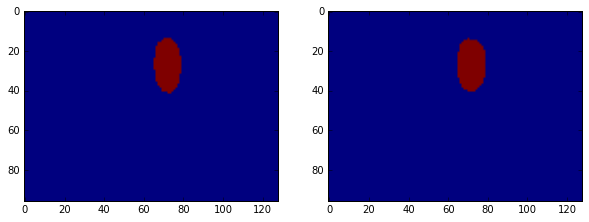

In [8]:
rand_i = 22
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(data_masks_val[rand_i])
plt.subplot(1,2,2)
plt.imshow(vae.predict_on_batch(data_masks_val[0:batch_size])[rand_i] > 0.5)

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(images, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()